<a href="https://colab.research.google.com/github/yoineko/skillfactory-module6/blob/master/fine_tuning_xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Это пример решения задачи с использованием Xception
# Классификация изображений

### Основная идея этого решения: взять предобученую на ImageNet сеть Xception и применить Transfer learning & fine-tuning.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DIR = '/content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Sun Aug 23 21:41:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    33W / 250W |  15525MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
from pathlib import Path


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB6, EfficientNetB7
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K


from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

#print(os.listdir("../input"))
print(os.listdir(DIR + "input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['sample-submission.csv', 'test.zip', 'train.csv', 'train.zip', 'train.gsheet', 'sample-submission.gsheet']
Python       : 3.6.9 (default, Jul 17 2020, 12:50:27) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Keras        : 2.4.0


**Работаем с Tensorflow v2**

In [ ]:
!pip freeze > requirements.txt

# Основные настройки

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 32 #64 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # начнем с малого 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# DATA_PATH = '../input/'
PATH = "../working/car/" # рабочая директория


DATA_PATH = DIR + 'input/'
ver = '6_6'

In [ ]:
# Устаналиваем конкретное значение random seed для воспроизводимости
#os.makedirs(PATH,  exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [ ]:
train_df = pd.read_csv(os.path.join(DATA_PATH,"train.csv"))
sample_submission = pd.read_csv(os.path.join(DATA_PATH,"sample-submission.csv"))

In [ ]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DIR + "/input/"+data_zip,"r") as z:    
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train']


# Подготовка данных

### Аугментация данных

In [ ]:
# Так как у нас небольшой датасет, то применем к нему аугментацию  данных.
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True,
    brightness_range=[0.5,1.5],
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
    )

test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    brightness_range=[0.5,1.5],
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
    )

### Генерация данных

In [ ]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

#test_sub_generator = test_datagen.flow_from_dataframe( 
test_sub_generator = train_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


# Построение модели

### Загружаем предобученную сеть Xception:

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [ ]:
# Устанавливаем новую "голову" (head)
base_model.training=False
x = base_model.output

x = Conv2D(512, kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
# let's add a fully-connected layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# чистит сессию в Keras и TF
def reset_tf_session():
    curr_session = tf.compat.v1.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.compat.v1.InteractiveSession(config=config)
 #   K.set_session(s)
    tf.compat.v1.keras.backend.set_session(s)

s = reset_tf_session()

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
 
    epochs = range(len(acc))
 
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.figure()
 
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
 
    plt.show()

## Обучение модели

In [ ]:
# Let's take a look to see how many layers are in the base model
base_layers = len(base_model.layers)
print("Number of layers in the base model: ", len(base_model.layers), len(model.layers))

Number of layers in the base model:  132 140


Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [ ]:
checkpoint = ModelCheckpoint(os.path.join(DIR, f'best_model/best_model{ver}.hdf5') , monitor = 'val_accuracy' , verbose = 1  , save_best_only = True, mode = 'max')
earlystop = EarlyStopping(patience=5, monitor='val_loss') #, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]


In [ ]:
# mode_train False - all layers frezee, True - all layers not frezee
def config_model(mode_train, l_r, ephochs,  fine_tune_at = 0):
    base_model.trainable = mode_train
    if fine_tune_at > 0 :

# Freeze all the layers before the `fine_tune_at` layer
      for layer in model.layers[:fine_tune_at]:
            layer.trainable =  False

# фиксируем настройку
    model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=l_r), metrics=["accuracy"])

# маленькая проверка перед обучением
    scores = model.evaluate(test_generator, steps=1, verbose=1)
    print("Accuracy before fit: %.2f%%" % (scores[1]*100))

#обучаем 
    history =    model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = ephochs,
        callbacks = callbacks_list
       )
    
    # сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
    model.save(os.path.join(DIR, f'working/model_last{ver}.hdf5'))

    model.load_weights(os.path.join(DIR, f'best_model/best_model{ver}.hdf5'))

# тестируем
    scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
    print("Accuracy after: %.2f%%" % (scores[1]*100))

#Анализируем поведение 
    plot_history(history)

##Применим Transfer learning & fine-tuning.

1/1 [==============================] - 0s 2ms/step - loss: 2.3231 - accuracy: 0.0000e+00
Accuracy before fit: 0.00%
Epoch 1/5
414/414 [==============================] - ETA: 0s - loss: 1.4870 - accuracy: 0.4575
Epoch 00001: val_accuracy improved from -inf to 0.55775, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model6_6.hdf5
414/414 [==============================] - 378s 914ms/step - loss: 1.4870 - accuracy: 0.4575 - val_loss: 1.1763 - val_accuracy: 0.5578
Epoch 2/5
414/414 [==============================] - ETA: 0s - loss: 1.0921 - accuracy: 0.6089
Epoch 00002: val_accuracy improved from 0.55775 to 0.62774, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model6_6.hdf5
414/414 [==============================] - 376s 908ms/step - loss: 1.0921 - accuracy: 0.6089 - val_loss: 1.0352 - val_accuracy: 0.6277
Epoch 3/5
414/414 [==============================] - ETA: 0s - loss: 0.9654 - accuracy: 0.6

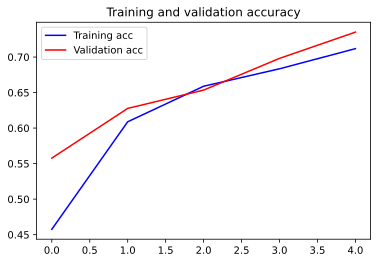

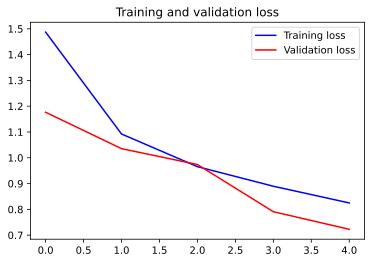

1/1 [==============================] - 0s 2ms/step - loss: 0.7212 - accuracy: 0.6250
Accuracy before fit: 62.50%
Epoch 1/10
414/414 [==============================] - ETA: 0s - loss: 0.5529 - accuracy: 0.8103
Epoch 00001: val_accuracy improved from 0.73508 to 0.89652, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model6_6.hdf5
414/414 [==============================] - 377s 910ms/step - loss: 0.5529 - accuracy: 0.8103 - val_loss: 0.3044 - val_accuracy: 0.8965
Epoch 2/10
414/414 [==============================] - ETA: 0s - loss: 0.2624 - accuracy: 0.9091
Epoch 00002: val_accuracy improved from 0.89652 to 0.90854, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model6_6.hdf5
414/414 [==============================] - 377s 911ms/step - loss: 0.2624 - accuracy: 0.9091 - val_loss: 0.2588 - val_accuracy: 0.9085
Epoch 3/10
414/414 [==============================] - ETA: 0s - loss: 0.1814 - accuracy: 

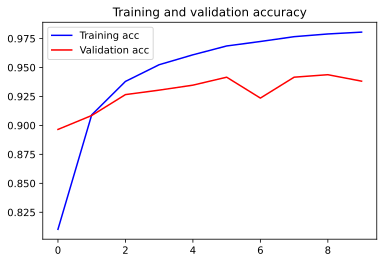

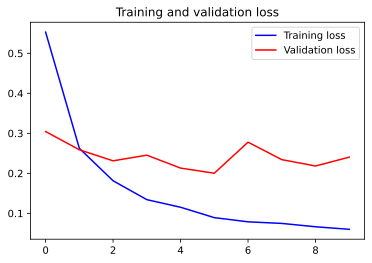

1/1 [==============================] - 0s 5ms/step - loss: 0.0054 - accuracy: 1.0000
Accuracy before fit: 100.00%
Epoch 1/10
414/414 [==============================] - ETA: 0s - loss: 0.0605 - accuracy: 0.9804
Epoch 00001: val_accuracy improved from 0.94375 to 0.94590, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model6_6.hdf5
414/414 [==============================] - 377s 911ms/step - loss: 0.0605 - accuracy: 0.9804 - val_loss: 0.1953 - val_accuracy: 0.9459
Epoch 2/10
414/414 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 0.9861
Epoch 00002: val_accuracy improved from 0.94590 to 0.95019, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model6_6.hdf5
414/414 [==============================] - 378s 914ms/step - loss: 0.0414 - accuracy: 0.9861 - val_loss: 0.2061 - val_accuracy: 0.9502
Epoch 3/10
414/414 [==============================] - ETA: 0s - loss: 0.0357 - accuracy:

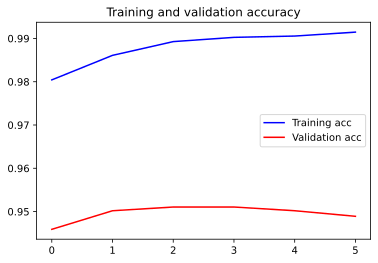

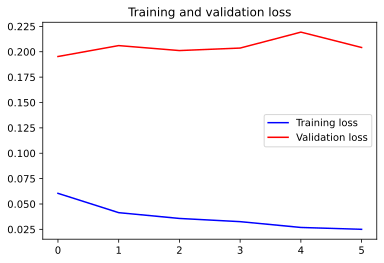

1/1 [==============================] - 0s 2ms/step - loss: 0.4576 - accuracy: 0.9375
Accuracy before fit: 93.75%
Epoch 1/10
414/414 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9893
Epoch 00001: val_accuracy improved from 0.95105 to 0.95449, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model6_6.hdf5
414/414 [==============================] - 375s 906ms/step - loss: 0.0300 - accuracy: 0.9893 - val_loss: 0.2197 - val_accuracy: 0.9545
Epoch 2/10
414/414 [==============================] - ETA: 0s - loss: 0.0253 - accuracy: 0.9914
Epoch 00002: val_accuracy improved from 0.95449 to 0.95492, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model6_6.hdf5
414/414 [==============================] - 373s 902ms/step - loss: 0.0253 - accuracy: 0.9914 - val_loss: 0.2029 - val_accuracy: 0.9549
Epoch 3/10
414/414 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 

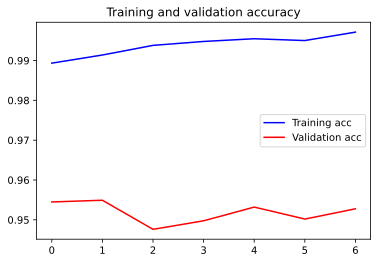

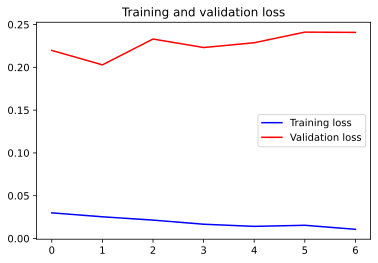

1/1 [==============================] - 0s 2ms/step - loss: 0.0980 - accuracy: 0.9375
Accuracy before fit: 93.75%
Epoch 1/10
414/414 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9927
Epoch 00001: val_accuracy did not improve from 0.95492
414/414 [==============================] - 383s 926ms/step - loss: 0.0230 - accuracy: 0.9927 - val_loss: 0.2223 - val_accuracy: 0.9506
Epoch 2/10
414/414 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.9929
Epoch 00002: val_accuracy did not improve from 0.95492
414/414 [==============================] - 382s 923ms/step - loss: 0.0223 - accuracy: 0.9929 - val_loss: 0.2243 - val_accuracy: 0.9515
Epoch 3/10
414/414 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9945
Epoch 00003: val_accuracy did not improve from 0.95492
414/414 [==============================] - 376s 907ms/step - loss: 0.0169 - accuracy: 0.9945 - val_loss: 0.2108 - val_accuracy: 0.9532
Epoch 4/10
414/414 [=========

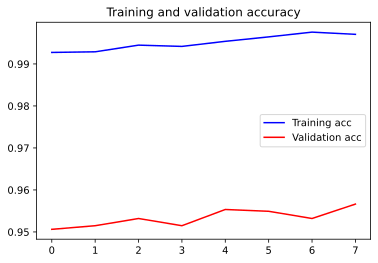

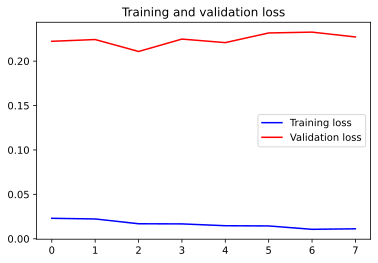

In [ ]:
base_layers = len(base_model.layers)
# step 1 Обучаем только голову
config_model(False, l_r = 1e-3, ephochs = 5,   fine_tune_at = 0)

# step 2 Разморозим половину слоев базовой модели, уменьшим шаг обучения и обучим модель
config_model(True, l_r = 1e-4, ephochs = 10,  fine_tune_at = base_layers//2)

# step 3 Оставим замороженными четверть слоев базовой модели, и еще уменьшим шаг обучения, обучим модель
config_model(True, l_r = 1e-5, ephochs = 10,  fine_tune_at = base_layers//4)

# step 4 Оставим замороженными восьмую часть слоев базовой модели, и обучим модель
config_model(True, l_r = 1e-5, ephochs = 10,  fine_tune_at = base_layers//8)

# step 5 Обучим на всех слояхеньшим шаг обучения, обучим модель
config_model(True, l_r = 6e-6, ephochs = 10 ,  fine_tune_at = 0)

Первый шаг обучения дает уже 73 % , неплохой результат

После второго шага точность возрастает до 94%

На остальных шагах точность растет незначительно, всего до 95,36 %, наблюдаются признаки переобучения 


Попробуем улучшить точность модели, увеличив картинку и уменьшив параметры аугментации.

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.
1/1 [==============================] - 0s 2ms/step - loss: 0.0082 - accuracy: 1.0000
Accuracy before fit: 100.00%
Epoch 1/30
414/414 [==============================] - ETA: 0s - loss: 0.0569 - accuracy: 0.9823
Epoch 00001: val_accuracy did not improve from 0.95663
414/414 [==============================] - 468s 1s/step - loss: 0.0569 - accuracy: 0.9823 - val_loss: 0.2088 - val_accuracy: 0.9515
Epoch 2/30
414/414 [==============================] - ETA: 0s - loss: 0.0568 - accuracy: 0.9824
Epoch 00002: val_accuracy improved from 0.95663 to 0.95749, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model6_6.hdf5
414/414 [==============================] - 469s 1s/step - loss: 0.0568 - accuracy: 0.9824 - val_loss: 0.1746 - val_accuracy: 0.9575
Epoch 3/30
414/414 [==============================] - ETA: 0s - loss: 0.0423 - acc

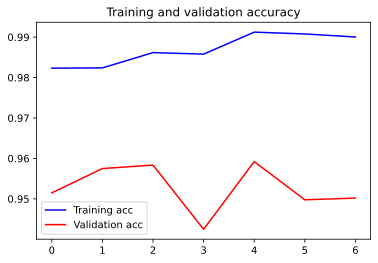

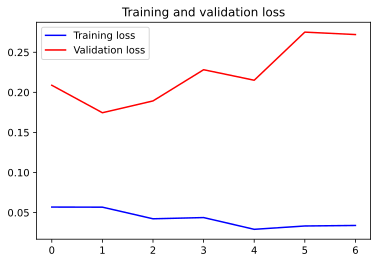

In [ ]:
# step 6
IMG_SIZE             = 350 
BATCH_SIZE           = 32

# подгрузим лучшую итерацию в обучении (best_model)
model.load_weights(os.path.join(DIR,f'best_model/best_model{ver}.hdf5'))

#Новые генераторы , так как меняем размер картинки
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 10,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True,
    shear_range=0.1,
    fill_mode='nearest'
    )

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = train_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

# Обучим модель
config_model( True, l_r = 1e-4, ephochs = 30 ,  fine_tune_at = 0)

Получаем увеличение точности, но весьма незначительное, наблюдается переобучение

# Предсказание на тестовых данных

In [ ]:
test_sub_generator.samples

6675

In [ ]:
from tqdm import tqdm

test_sub_generator.reset()
tta_steps = 10
l_predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    l_predictions.append(preds)

pred = np.mean(l_predictions, axis=0)

predictions = np.argmax(pred, axis=-1)
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

  0%|          | 0/10 [00:00<?, ?it/s]

Instructions for updating:
Please use Model.predict, which supports generators.
209/209 [==============================] - 172s 821ms/step


 10%|█         | 1/10 [02:54<26:06, 174.04s/it]

209/209 [==============================] - 171s 818ms/step


 20%|██        | 2/10 [05:46<23:09, 173.64s/it]

209/209 [==============================] - 171s 820ms/step


 30%|███       | 3/10 [08:39<20:14, 173.51s/it]

209/209 [==============================] - 173s 826ms/step


 40%|████      | 4/10 [11:34<17:22, 173.80s/it]

209/209 [==============================] - 172s 824ms/step


 50%|█████     | 5/10 [14:28<14:29, 173.86s/it]

209/209 [==============================] - 171s 817ms/step


 60%|██████    | 6/10 [17:21<11:34, 173.50s/it]

209/209 [==============================] - 172s 822ms/step


 70%|███████   | 7/10 [20:14<08:40, 173.55s/it]

209/209 [==============================] - 171s 818ms/step


 80%|████████  | 8/10 [23:07<05:46, 173.32s/it]

209/209 [==============================] - 172s 825ms/step


 90%|█████████ | 9/10 [26:01<02:53, 173.61s/it]

209/209 [==============================] - 171s 818ms/step


100%|██████████| 10/10 [28:54<00:00, 173.47s/it]


In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv(DIR + f'submission/submission_{ver}.csv', index=False)
print('Save submit')

# Рекомендация: попробуйте добавить Test Time Augmentation (TTA)
# https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

Save submit


In [ ]:
submission.head()

,Id,Category
0,305108.jpg,2
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,9


Весьма скромный результат на kaggle 0.96224
